This code implements a symulation software for the S-ICEP problem.


In [1]:
import numpy as np
import random as rm
import math
import pandas as pd
from scipy.stats import uniform
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from getStats import getStats
from earthQuake import EarthQuake
from flood import Flood
from population import Population
from weather import Weather
from scenario import Scenario
from utils import Utils
import random

We as first set initial parameters

In [2]:
numScenarios = 25
T = 365 *1
totPop = 1000
weather = Weather(T)

{p01: 6.80881084733803e-6, p11: 0.994542327936530}


Let'run our simulation;
The first stage of the process consists of symulating wet/dry days by means of a 2-states markov process: dry days or wet days.
Each trasnsition is associated to a transition probability, then we have: 
$$M = \begin{pmatrix}
p_{00} & p_{01} \\
 p_{10} & p_{11}
\end{pmatrix}$$

$$p_{01}:  \text{probability of wet day after dry day} \\
p_{11}:  \text{probability of wet day after wetday} \\
p_{00} = 1 -  p_{01} \\
p_{10} = 1 -  p_{11}
$$


Each "weather game" iterates as follows:
![weather game](./images/weather-game.png "Title")





For each day models "decides" wether it is rainy or not, if yes then calculates the effectively rain amount by using an exponential distribution of mean u $$f(x) = (1/\mu ) \mathrm{e}_{}^{-x/\mu}$$

In [3]:
weatherData = weather.weatherGame()


Next we proceed to sample non precipitational variable, that are:
<ul>
<li> Min temperatures </li>
<li> Max temperatures </li>
<li> Solar radiation </li>
</ul>
Note:
Those quantities, are poorly considered for the natural disaster triggering (see flood), but are usefull to compute severity parameters during an evacuation, affecting times, visibility etc.

Quantities, (t_min, t_max, rad) are extracted from a stochastic Auto Regressive first-order process, defined by:
$$z(t) = Az(t-1) + B \epsilon(t) $$
where 
$$ z(t) =  \begin{pmatrix}
\mathrm{z}_{t_m}^{} \\
\mathrm{z}_{t_M}^{} \\
 \mathrm{z}_{rad}^{}\\

\end{pmatrix}

\\\epsilon(t) \sim G(0, 1)
$$ 
and 

$$
A = \begin{pmatrix}
0.567 & 0.086 & -0.002 \\
0.253 & 0.504 & -0.05 \\
-0.006 & -0.039 & 0.244
\end{pmatrix}

B = \begin{pmatrix}
0.781& 0 & 0 \\
0.328 & 0.637 & 0 \\
0.238 & -0.341 & 0.873
\end{pmatrix}
$$

Note: A and B are given from [PAPER]


Once they have been generated, the z(t) are transformed to weather
variables in a way that depends on whether the day has been simulated to be wet or
dry
$$\mathrm{T}_{k}^{}(t) = \begin{cases} \mathrm{\mu}_{k,0}^{}(t) + \mathrm{\sigma}_{k,0}^{}(t) \mathrm{z}_{k}^{}(t) & \text{if is a dry day}
\\ \mathrm{\mu}_{k,1}^{}(t) + \mathrm{\sigma}_{k,1}^{}(t) \mathrm{z}_{k}^{}(t) & \text{if is a wet day}
\end{cases}$$

Where seasonal fluctuation are considered by imposing to means a sinusoidal time-dependent behaviour, indeed:
$$\mu(t) = \overline{\mu} + C cos (0.0172(t -T))$$


In [4]:
dailyRain, t_min, t_max, radiaz = weatherData


Let's move on population data generation:
Since the of population follows a cyclical behaviour during the year it is reasonable to represent it with one (or more) sinusoids, plus some uncertainty extracted from a normal distibution
$$
population(t) = \overline{pop} * (1 + \left[ Acos(0.0172t) + Bcos(0.0172t +\Phi) \right] + C \epsilon(t))
\\
\epsilon(t) \sim G(0, 1)
$$

In [5]:
population = Population(totPop, T)


Then we can plot results:

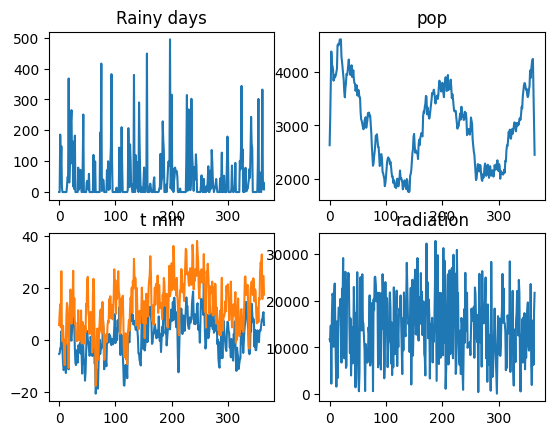

In [6]:

fig1, axs1 = plt.subplots(2, 2)

X = range(0, T)

axs1[0][0].plot(X, dailyRain[0:T] )
axs1[0][0].set_title('Rainy days')

axs1[1][0].plot(X, t_min, t_max)
axs1[1][0].set_title('t min')

axs1[0][1].plot(X,  population.getPopWave() )
axs1[0][1].set_title('pop')

axs1[1][1].plot(X,  radiaz )
axs1[1][1].set_title('radiation')

plt.show()


LEt's move on now to sampling natural disasters, we start from a random sampled day, compute the corresponding weather variables and evaluate the probabilty of the emergency:
Two types of disaster are considered: 
<ul>
<li> Earthqwakes: following the <a  href="https://en.wikipedia.org/wiki/Gutenberg%E2%80%93Richter_law"  > Gutenberg-Richter distribution </a>
<li> Floods: following an <a href="https://en.wikipedia.org/wiki/100-year_flood#:~:text=A%20100%2Dyear%20flood%20is,exceeded%20in%20any%20given%20year."> 100-year flood probability </a> 

</ul>

In [7]:

scenarios = []
tIstants = []
mostRainyWeeks = weather.setMostRainyWeeks(numScenarios)

for ns in range(numScenarios):
    disasterType = random.randint(1, 2)
    if disasterType == 1:
        timeIstant = random.randint(0, T)
    else:
        index = random.sample(range(len(mostRainyWeeks)), 1)[0]
        sample = mostRainyWeeks[index]
        mostRainyWeeks = np.delete(mostRainyWeeks, index)
        timeIstant = int(sample)
    
    scenario = Scenario(population, weather, numScenarios, timeIstant, disasterType)
    s = scenario.sampleScenario()
    scenarios.append(s)
    tIstants.append(s.timeIstant)

In [8]:
X = range(0, T)
df = pd.DataFrame(columns=['day', 'population', 'rainAmount', 't_min', 't_max', 'radiation', 'disaster', 'Relative Probability'])

df['day'] = tIstants

df['population'] = [int(s.population) for s in scenarios]
df['rainAmount'] = [int(s.rainAmount) for s in scenarios]
df['t_min'] = [int(s.tempMin) for s in scenarios]
df['t_max'] = [int(s.tempMax) for s in scenarios]
df['radiation'] = [int(s.radiation) for s in scenarios]
# df['flood'] = [s.flooding[0] for s in scenarios]
# df['earthqwake'] =  [s.earthqwake[0] for s in scenarios]
# df['probability'] = [s.probability for s in scenarios]
df['Relative Probability'] = Utils.normalizeProbs([s.probability for s in scenarios])
disasterTypes = []
for s in scenarios:
    dis = "Flood" if s.flooding[0] > 0 else "Earthquake, Mag: "+str(s.earthqwake[0] )
    disasterTypes.append(dis)
df['disaster'] = disasterTypes

df.sort_values(by=['day'], inplace=True)

df


,day,population,rainAmount,t_min,t_max,radiation,disaster,Relative Probability
3,16,4496,46,-7,3,18513,Flood,7.321227e-02
0,17,4535,367,-11,-10,18390,Flood,6.017881e-02
10,18,4606,30,1,6,17118,Flood,9.190962e-02
8,25,3843,18,14,26,8271,"Earthquake, Mag: 5",7.764584e-04
23,66,3032,0,-18,-14,7765,"Earthquake, Mag: 10",6.070891e-08
21,100,2030,0,-1,22,13175,"Earthquake, Mag: 7",1.924641e-05
5,110,2120,33,2,9,15342,"Earthquake, Mag: 7",2.170128e-05
19,121,1996,0,-14,-9,13929,"Earthquake, Mag: 10",4.633427e-08
6,173,3208,0,0,21,17295,"Earthquake, Mag: 9",4.927168e-07
22,189,3490,0,2,13,16291,"Earthquake, Mag: 12",1.485867e-09


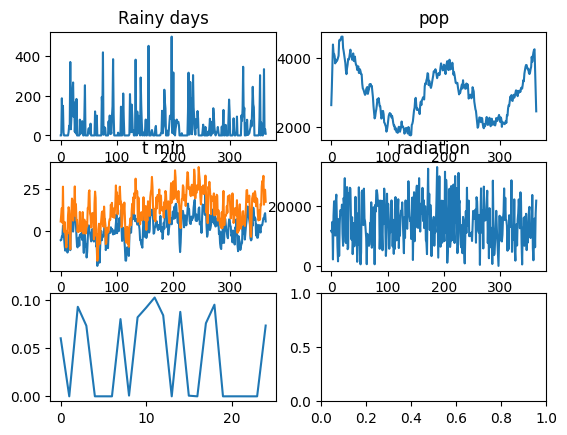

In [9]:
fig1, axs1 = plt.subplots(3, 2)

axs1[0][0].plot(X, dailyRain[0:T] )
axs1[0][0].set_title('Rainy days')

axs1[1][0].plot(X, t_min, t_max)
axs1[1][0].set_title('t min')

axs1[0][1].plot(X,  population.getPopWave() )
axs1[0][1].set_title('pop')

axs1[1][1].plot(X,  radiaz )
axs1[1][1].set_title('radiation')

axs1[2][0].plot([x for x in range(len(tIstants))], Utils.normalizeProbs([s.probability for s in scenarios]))
axs1[2][0]

plt.show()